In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
n = 272474
n_samples = 2
Ks = range(100,500,1)

n_samples,_,_,_,GQ_ave = np.load(f'data/wass/resnet20.npy',allow_pickle=True)
lb,ub = np.min(GQ_ave[3000].get_distr()),np.max(GQ_ave[3000].get_distr())

GQ = {k:[] for k in Ks}
GQ_lower = {k:[] for k in Ks}
GQ_upper = {k:[] for k in Ks}

for trial in range(n_samples):
    a_,b_ = np.load(f'data/resnet20_cifar10_3000_{trial}.npy',allow_pickle=True)

    for k in Ks:
        GQ[k].append(get_GQ_distr(a_[:k],b_[:k-1]))

        # define upper and lower bounds
        GQ_lower[k].append(get_GQ_lower_bound(GQ[k][-1],lb,ub))
        GQ_upper[k].append(get_GQ_upper_bound(GQ[k][-1],lb,ub))

GQ_ave = {}
GQ_lower_ave = {}
GQ_upper_ave = {}

for k in Ks:
   # average bounds
    GQ_ave[k] = get_ave_distr(GQ[k])
    GQ_lower_ave[k] = get_ave_distr(GQ_lower[k])
    GQ_upper_ave[k] = get_ave_distr(GQ_upper[k]) 
    

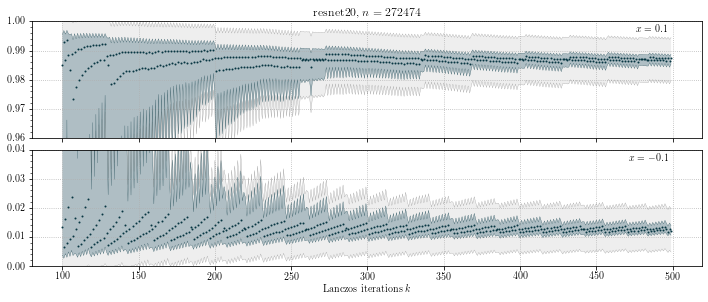

In [4]:
xs = [.1,-.1]
lims = [(.96,1.),(0.,.04)]

eta = 0.01
eps = np.sqrt( (n+2)**(-1) * n_samples**(-1) * np.log(2*n/(eta)) )


fig,axs = plt.subplots(2,1,figsize=(12,4.5),sharex=True)
fig.subplots_adjust(hspace=.1)

name = 'resnet20'

for i in range(2):
    
    x = xs[i]
    
    GQ_vals = np.array([GQ_ave[k](x) for k in Ks])
    GQ_upper_vals = np.array([GQ_upper_ave[k](x) for k in Ks])
    GQ_lower_vals = np.array([GQ_lower_ave[k](x) for k in Ks])
    GQ_upper_eps_vals = np.array([np.clip(GQ_upper_ave[k](x)+eps,0,1) for k in Ks])
    GQ_lower_eps_vals = np.array([np.clip(GQ_lower_ave[k](x)-eps,0,1) for k in Ks])


    axs[i].plot(Ks,GQ_vals,ls='None',marker='.',ms=2,color='#073642')

    axs[i].fill_between(Ks,GQ_upper_eps_vals,GQ_lower_eps_vals,facecolor='#eeeeee')
    axs[i].plot(Ks,GQ_upper_eps_vals,ls='-',lw=.25,marker='None',color='#888888')
    axs[i].plot(Ks,GQ_lower_eps_vals,ls='-',lw=.25,marker='None',color='#888888')

    axs[i].fill_between(Ks,GQ_upper_vals,GQ_lower_vals,facecolor='#afbec4')
    axs[i].plot(Ks,GQ_upper_vals,ls='-',lw=.25,marker='None',color='#073642')
    axs[i].plot(Ks,GQ_lower_vals,ls='-',lw=.25,marker='None',color='#073642')

    axs[i].grid(True,ls=':')
    axs[i].set_ylim(*lims[i])
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_yticks(np.arange(lims[i][0],lims[i][1]+.001,.01))
    
    axs[i].text(.95,.9,f'$x={x}$',horizontalalignment='right',transform=axs[i].transAxes)


axs[0].set_title(f"{name.replace('_',' ')}, $n={n}$")#" $x={x}$, $n_{{\mathrm{{v}}}}={n_samples}$, $t={eps}$")#", $\lambda_{{\mathrm{{min}}}}={np.min(lam):1.0f}$, $\lambda_{{\mathrm{{max}}}}={np.max(lam):1.0f}$")

axs[1].set_xlabel('Lanczos iterations $k$')
    
#fig.suptitle(f"{name.replace('_',' ')}, $n={n}$",y=1.1)

plt.savefig('imgs/epsrank_bounds.pdf',bbox_inches='tight')